In [17]:
import pandas as pd
import seaborn as sns

nginx = {
    "name": "nginx",
    "ip": "nginx.antoniszczepanik.com",
}

h2o = {
    "name": "h2o",
    "ip": "h2o.antoniszczepanik.com",
}

caddy = {
    "name": "caddy",
    "ip": "caddy.antoniszczepanik.com",
}

ls = {
    "name": "openlitespeed",
    "ip": "litespeed.antoniszczepanik.com",
}

iperf_port = "6969"

servers = (nginx, h2o, caddy, ls)

## Bandwidth and latency test

### Latency

In [2]:
for server in servers:
    print("")
    print(f"==================== PING {server['name']} ==========================")
    !ping -c 5 {server["ip"]}


==================== PING nginx ==========================
PING nginx.antoniszczepanik.com (18.159.234.10) 56(84) bytes of data.
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=1 ttl=63 time=0.287 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=2 ttl=63 time=0.262 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=3 ttl=63 time=0.274 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=4 ttl=63 time=0.230 ms
64 bytes from ec2-18-159-234-10.eu-central-1.compute.amazonaws.com (18.159.234.10): icmp_seq=5 ttl=63 time=0.242 ms

--- nginx.antoniszczepanik.com ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4067ms
rtt min/avg/max/mdev = 0.230/0.259/0.287/0.020 ms

==================== PING h2o ==========================
PING h2o.antoniszczepanik.com (3.72.136.224) 56(84) bytes of data.


### Bandwidth - TCP & UDP

In [21]:
# TODO: Make sure iperf is running on all servers.
!iperf -c {nginx["ip"]} -p {iperf_port}
!iperf -u -c {nginx["ip"]} -p {iperf_port} -b 0

Connecting to host 3.69.173.4, port 6969
[  5] local 172.31.13.42 port 36580 connected to 3.69.173.4 port 6969
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.00   sec   360 MBytes  3.02 Gbits/sec  328    532 KBytes       
[  5]   1.00-2.00   sec   378 MBytes  3.17 Gbits/sec  237    301 KBytes       
[  5]   2.00-3.00   sec   398 MBytes  3.33 Gbits/sec  211    433 KBytes       
[  5]   3.00-4.00   sec   439 MBytes  3.68 Gbits/sec  389    542 KBytes       
[  5]   4.00-5.00   sec   488 MBytes  4.09 Gbits/sec  343    400 KBytes       
[  5]   5.00-6.00   sec   460 MBytes  3.86 Gbits/sec  287    580 KBytes       
[  5]   6.00-7.00   sec   412 MBytes  3.46 Gbits/sec  366    673 KBytes       
[  5]   7.00-8.00   sec   512 MBytes  4.30 Gbits/sec  351    550 KBytes       
[  5]   8.00-9.00   sec   511 MBytes  4.29 Gbits/sec  590    375 KBytes       
[  5]   9.00-10.00  sec   455 MBytes  3.82 Gbits/sec  360    481 KBytes       
- - - - - - - - - - - - - - - - - 

### Measuring QUIC performance

#### h2 load output parsing

In [3]:
def get_throughput(res):
    fin_line = [l for l in res if l.startswith("finished in ")][0]
    return float(fin_line.split(" ")[-1][:-4])

def get_rps(res):
    fin_line = [l for l in res if l.startswith("finished in ")][0]
    return float(fin_line.split(" ")[3])

def get_success_pct(res):
    req_line = [l for l in res if l.startswith("requests:")][0]
    items = req_line.split(" ")
    return float(items[7])/float(items[1])

#### Bulk Throughput

Get throughput measurment from the client.

In [21]:
data_tp = {
    "server": [],
    "throughput": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3",):
        print(f"bulk throughput test {protocol} - {server['name']}")
        # Request the file first, just to warm up caches.
        _ = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
        for i in range(20):
            res = !h2load -n1 -c1 --npn-list={protocol} https://{server['ip']}/1g.txt
            data_tp['server'].append(server['name'])
            data_tp['throughput'].append(get_throughput(res))
            data_tp['protocol'].append(protocol)
            print(f"{get_throughput(res)} MB/s (succ: {get_success_pct(res)})")

bulk throughput test h2 - nginx
559.98 MB/s (succ: 1.0)
482.55 MB/s (succ: 1.0)
532.33 MB/s (succ: 1.0)
547.69 MB/s (succ: 1.0)
464.95 MB/s (succ: 1.0)
548.6 MB/s (succ: 1.0)
409.47 MB/s (succ: 1.0)
552.58 MB/s (succ: 1.0)
537.14 MB/s (succ: 1.0)
509.1 MB/s (succ: 1.0)
561.3 MB/s (succ: 1.0)
454.83 MB/s (succ: 1.0)
543.93 MB/s (succ: 1.0)
541.55 MB/s (succ: 1.0)
290.84 MB/s (succ: 1.0)
452.06 MB/s (succ: 1.0)
524.38 MB/s (succ: 1.0)
522.94 MB/s (succ: 1.0)
528.83 MB/s (succ: 1.0)
429.65 MB/s (succ: 1.0)
bulk throughput test h3 - nginx
152.24 MB/s (succ: 1.0)
153.66 MB/s (succ: 1.0)
148.6 MB/s (succ: 1.0)
150.52 MB/s (succ: 1.0)
145.3 MB/s (succ: 1.0)
146.37 MB/s (succ: 1.0)
159.89 MB/s (succ: 1.0)
165.56 MB/s (succ: 1.0)
157.87 MB/s (succ: 1.0)
155.24 MB/s (succ: 1.0)
135.85 MB/s (succ: 1.0)
154.52 MB/s (succ: 1.0)
163.39 MB/s (succ: 1.0)
153.02 MB/s (succ: 1.0)
162.83 MB/s (succ: 1.0)
162.68 MB/s (succ: 1.0)
150.84 MB/s (succ: 1.0)
145.77 MB/s (succ: 1.0)
162.14 MB/s (succ: 1.0)
165.2

,server,throughput,protocol
0,nginx,559.98,h2
1,nginx,482.55,h2
2,nginx,532.33,h2
3,nginx,547.69,h2
4,nginx,464.95,h2
...,...,...,...
155,openlitespeed,313.15,h3
156,openlitespeed,289.94,h3
157,openlitespeed,311.57,h3
158,openlitespeed,276.79,h3


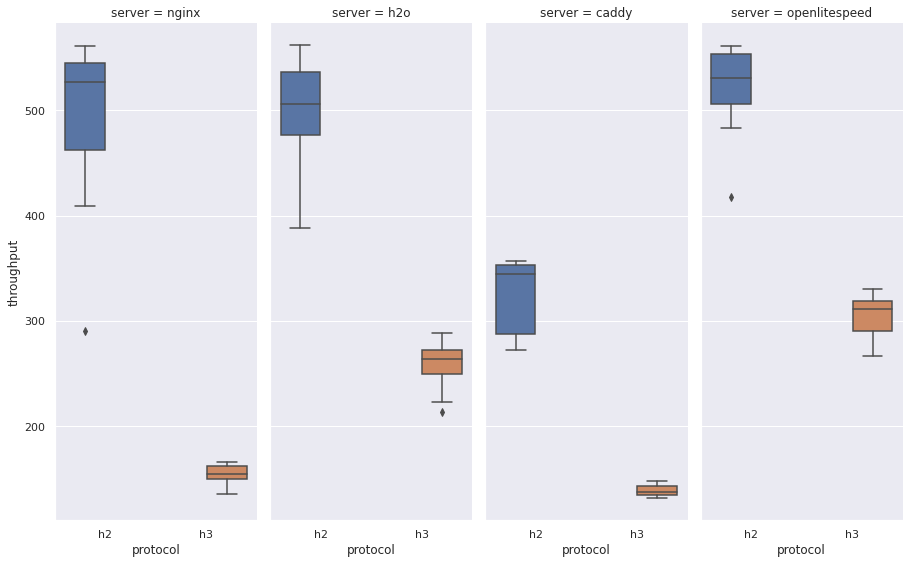

In [43]:
df_tp = pd.DataFrame(data_tp)

sns.set(rc={'figure.figsize':(20,10)})

# ax = sns.boxplot(x="server", y="throughput", hue="protocol", data=df_tp, palette="Set3")

g = sns.catplot(x="protocol", y="throughput",hue="protocol", col="server",data=df_tp, kind="box",height=8, aspect=.4);

In [50]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for i in range(10):
            res = !h2load -n100000 -t $(nproc) -c 50 -m 100 --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append(protocol)
            print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")

rps test h2 - nginx
45704.19 req/s (succ: 1.000)
47069.61 req/s (succ: 1.000)
48975.19 req/s (succ: 1.000)
49295.49 req/s (succ: 1.000)
48123.31 req/s (succ: 1.000)
48592.0 req/s (succ: 1.000)
48944.18 req/s (succ: 1.000)
48435.51 req/s (succ: 1.000)
48746.2 req/s (succ: 1.000)
49927.88 req/s (succ: 1.000)
rps test h3 - nginx
75489.3 req/s (succ: 1.000)
75056.2 req/s (succ: 1.000)
74535.2 req/s (succ: 1.000)
73083.98 req/s (succ: 1.000)
74052.3 req/s (succ: 1.000)
74625.14 req/s (succ: 1.000)
74305.36 req/s (succ: 1.000)
73762.63 req/s (succ: 1.000)
72580.37 req/s (succ: 1.000)
76424.9 req/s (succ: 1.000)
rps test h2 - h2o
114606.74 req/s (succ: 1.000)
191797.58 req/s (succ: 1.000)
213744.64 req/s (succ: 1.000)
219274.2 req/s (succ: 1.000)
219148.78 req/s (succ: 1.000)
222685.9 req/s (succ: 1.000)
217448.5 req/s (succ: 1.000)
213003.43 req/s (succ: 1.000)
219248.72 req/s (succ: 1.000)
216362.17 req/s (succ: 1.000)
rps test h3 - h2o
131516.82 req/s (succ: 1.000)
138625.5 req/s (succ: 1.

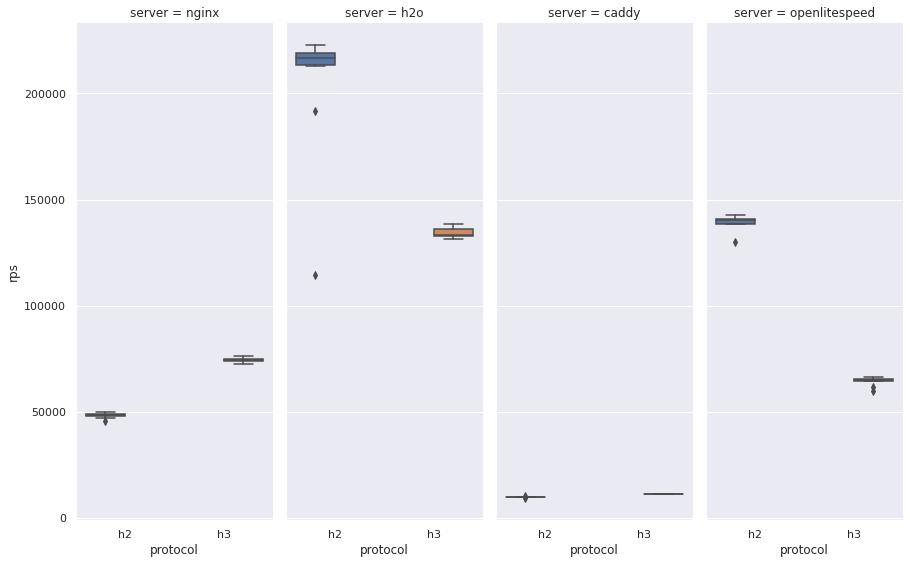

In [51]:
df_rps= pd.DataFrame(data_rps)
sns.set(rc={'figure.figsize':(20,10)})
# ax = sns.boxplot(x="server", y="throughput", hue="protocol", data=df_tp, palette="Set3")
g = sns.catplot(x="protocol", y="rps",hue="protocol", col="server",data=df_rps, kind="box",height=8, aspect=.4);

In [ ]:
# RPS with single connection (vary multiplexing level)

In [52]:
data_rps = {
    "server": [],
    "rps": [],
    "protocol": [],
}

for server in servers:
    for protocol in ("h2", "h3"):
        print(f"rps test {protocol} - {server['name']}")
        for i in range(10):
            res = !h2load -n100000 -t $(nproc) -c $(nproc) -m 100 --npn-list={protocol} https://{server['ip']}/index.html
            data_rps['server'].append(server['name'])
            data_rps['rps'].append(get_rps(res))
            data_rps['protocol'].append(protocol)
            print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")

rps test h2 - nginx
36608.7 req/s (succ: 1.000)
50867.44 req/s (succ: 1.000)
36801.16 req/s (succ: 1.000)
50348.16 req/s (succ: 1.000)
49503.63 req/s (succ: 1.000)
50327.0 req/s (succ: 1.000)
50095.46 req/s (succ: 1.000)
39849.34 req/s (succ: 1.000)
39483.1 req/s (succ: 1.000)
47323.73 req/s (succ: 1.000)
rps test h3 - nginx
76520.52 req/s (succ: 1.000)
76747.91 req/s (succ: 1.000)
78814.57 req/s (succ: 1.000)
78468.36 req/s (succ: 1.000)
78714.25 req/s (succ: 1.000)
77212.33 req/s (succ: 1.000)
77102.67 req/s (succ: 1.000)
78746.61 req/s (succ: 1.000)
74797.45 req/s (succ: 1.000)
76410.77 req/s (succ: 1.000)
rps test h2 - h2o
187003.27 req/s (succ: 1.000)
173920.0 req/s (succ: 1.000)
207753.79 req/s (succ: 1.000)
239831.73 req/s (succ: 1.000)
236131.41 req/s (succ: 1.000)
212409.83 req/s (succ: 1.000)
240792.11 req/s (succ: 1.000)
208428.86 req/s (succ: 1.000)
208197.57 req/s (succ: 1.000)
207250.45 req/s (succ: 1.000)
rps test h3 - h2o
121543.46 req/s (succ: 1.000)
121724.99 req/s (s

IndexError: list index out of range

In [64]:
for i in range(1, 101):
    res = !h2load -D1s -t $(nproc) -c $(nproc) -m {i} --npn-list=h2 https://{ls['ip']}/index.html
    print(f"{get_rps(res)} req/s (succ: {get_success_pct(res):.3f})")

5009.0 req/s (succ: 1.000)
10682.0 req/s (succ: 1.000)
17400.0 req/s (succ: 1.000)
20164.0 req/s (succ: 1.000)
24180.0 req/s (succ: 1.000)
30366.0 req/s (succ: 1.000)
33845.0 req/s (succ: 1.000)
40440.0 req/s (succ: 1.000)
41049.0 req/s (succ: 1.000)
51360.0 req/s (succ: 1.000)
47443.0 req/s (succ: 1.000)
49944.0 req/s (succ: 1.000)
56160.0 req/s (succ: 1.000)
59626.0 req/s (succ: 1.000)
62760.0 req/s (succ: 1.000)
64224.0 req/s (succ: 1.000)
67167.0 req/s (succ: 1.000)
72900.0 req/s (succ: 1.000)
76570.0 req/s (succ: 1.000)
79760.0 req/s (succ: 1.000)
78372.0 req/s (succ: 1.000)
70092.0 req/s (succ: 1.000)
80477.0 req/s (succ: 1.000)
84120.0 req/s (succ: 1.000)
81550.0 req/s (succ: 1.000)
88556.0 req/s (succ: 1.000)
87075.0 req/s (succ: 1.000)
88172.0 req/s (succ: 1.000)
95990.0 req/s (succ: 1.000)
90630.0 req/s (succ: 1.000)
92132.0 req/s (succ: 1.000)
83776.0 req/s (succ: 1.000)
93126.0 req/s (succ: 1.000)
95370.0 req/s (succ: 1.000)
87430.0 req/s (succ: 1.000)
90000.0 req/s (succ: 